# US Road Accidents Forecasting Models for Top 10 States

Import libraries and Data

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from colorama import Fore
import seaborn as sn

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
df = pd.read_csv("US_Accidents_Dec20.csv")
df['Date'] = pd.to_datetime(df['Start_Time']).dt.date #short date
df['Date'] = pd.to_datetime(df['Date']) #convert back to date
#filter for California state to build daily forecast models for each city
df = df.loc[df.State.isin(['CA','TX','FL','SC','NC','NY','PA','MI','IL', 'GA'])]
#select columns of interest
df = df[['Date', 'State', 'Temperature(F)', 'Pressure(in)','Visibility(mi)', 'Weather_Condition']]
#roll up the accidents to day level
df = df.groupby(['Date', 'State']).agg({'Temperature(F)' : ['mean', 'count'], \
                                                  'Pressure(in)' : 'mean', 'Visibility(mi)' : 'mean', \
                                                  'Weather_Condition': 'first'}).reset_index()
#convert multi level index to single level index
df.columns = ['_'.join(col) for col in df.columns.values]
df.rename(columns={'Temperature(F)_count':'DailyAccidents', 'Temperature(F)_mean':'Temperature', \
                  'Pressure(in)_mean':'Pressure', 'Visibility(mi)_mean':'Visibility', \
                  'Weather_Condition_first':'Weather_Condition', \
                  'Date_':'Date', \
                  'State_':'State', \
                  }, inplace=True)
df.head(5)

,Date,State,Temperature,DailyAccidents,Pressure,Visibility,Weather_Condition
0,2016-02-09,MI,31.000,2,29.590,1.85,Light Snow
1,2016-02-09,PA,29.450,2,29.585,1.25,Light Snow
2,2016-02-10,PA,21.500,3,29.750,1.60,Light Snow
3,2016-02-11,PA,14.725,4,30.285,10.00,Mostly Cloudy
4,2016-02-12,MI,23.000,1,29.960,10.00,Mostly Cloudy


# Plot Road Accidents time series data by States (Top 10)
Data exibits time series characteristics such daily/weekly/yearly seasonality and potentially a good candidate for time-series modeling:

Text(0.5, 1.0, 'US Road Accidents over time for top 10 States')

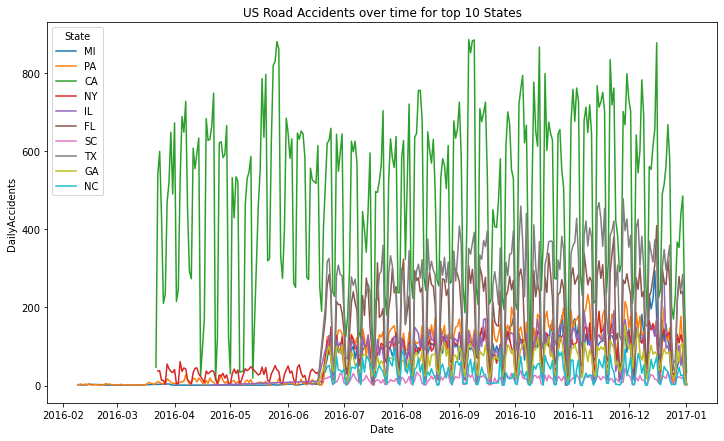

In [6]:
plt.rcParams["figure.figsize"] = (12,7)
sn.lineplot(data = df[['Date','State', 'DailyAccidents']].loc[df.Date<='2017-01-01'], \
            x='Date', y='DailyAccidents', hue='State').set_title('US Road Accidents over time for top 10 States')

## Split train test for modeling

In [7]:
train_start_date, train_end_date = '2016-02-09', '2019-01-31'
test_start_date, test_end_date = '2019-02-01', '2019-06-30'

train_df = df.loc[(df.Date>= train_start_date) & (df.Date<= train_end_date)]
train_df = train_df.fillna(method='ffill')
test_df = df.loc[(df.Date>= test_start_date) & (df.Date<= test_end_date)]
test_df = test_df.fillna(method='ffill')

# Generalized Additive Model (Prophet Model)

In [8]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, add_changepoints_to_plot
import warnings
warnings.filterwarnings ("ignore") #ignore warnings

UniqueStates = df.State.unique()
features = ["Temperature", "Pressure", "Visibility"]#features
test_size=(pd.to_datetime(test_end_date) - pd.to_datetime(train_end_date)).days

dfcolumns = ["Date", "State", "DailyAccidents", "Forecast"]
forecast_all_df = pd.DataFrame(columns= dfcolumns)

UniqueStates = ['CA']
#loop through each state to build time series models
for state in UniqueStates:
    print(state)
    
    localdf = train_df.loc[train_df.State == state].copy()#train df local copy
    dfm  = localdf[["Date", "DailyAccidents"]].copy()
    dfm = dfm.sort_values("Date")
    dfm.columns = ['ds','y'] #required for calling in prophet
    dfm['ds'] = pd.to_datetime(dfm['ds'], format="%Y-%m-%d").dt.date
    #add features
    for f in features:
        dfm[f] = localdf[[f]]        
        
    #instantiate model object
    m = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=True, mcmc_samples=500, n_changepoints=0)
    #for adding regressors to model
    for f in features:
        m.add_regressor(f)
    #fit
    m.fit(dfm) 
    #prepare for predict function
    future = m.make_future_dataframe(periods=test_size, freq='D')
    #add features for predict dataframe
    for f in features:
        future[f] = np.array(df.loc[(df.State == state) & (df.Date >= train_start_date) & (df.Date <= test_end_date)].fillna(method='ffill')[[f]])
        
    forecast = m.predict(future)
    forecast_df = forecast #do not change original df from prophet
    forecast_df['DailyAccidents'] = np.array(df.loc[(df.State == state) & (df.Date >= train_start_date) & (df.Date <= test_end_date)][['DailyAccidents']])
    forecast_df['State'] = state
    forecast_df.rename(columns= {'ds': 'Date', 'yhat': 'Forecast'}, inplace=True)
    forecast_df = forecast_df[dfcolumns]
    forecast_df = forecast_df.loc[(forecast_df.Date>= test_start_date) & (forecast_df.Date<= test_end_date)]
    forecast_all_df = pd.concat([forecast_all_df , forecast_df])
    del forecast, forecast_df

Importing plotly failed. Interactive plots will not work.


CA


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Plot the Forecast, calcuate RMSE and show forecast components:
1. Models are able to pick up weekly seasonality pretty well
2. The effect of external signals such as Pressure, Temperature are significant
3. Model out of sample RMSE is shown below for each state

In [83]:
from sklearn.metrics import mean_squared_error
rmse_list =[]
for state in UniqueStates:
    testdf = forecast_all_df.loc[forecast_all_df.State==state]
    rmse = np.round(mean_squared_error(testdf.DailyAccidents, testdf.Forecast, squared=False),2)
    mean_accidents_actual = np.median(testdf[["DailyAccidents"]])
    rmse_list.append([state, rmse, 'Prophet', mean_accidents_actual])

prophet_rmse = pd.DataFrame (rmse_list, columns=['State', 'RSME (test)', 'Model', 'ActualDailyAccidentsMedian'])
prophet_rmse.to_csv('Prophet_RMSE.csv')
prophet_rmse.sort_values('ActualDailyAccidentsMedian', ascending=False)

,State,RSME (test),Model,ActualDailyAccidentsMean
2,CA,77.52,Prophet,388.5
7,TX,48.65,Prophet,234.5
5,FL,45.60,Prophet,178.0
6,SC,67.39,Prophet,173.0
9,NC,73.02,Prophet,148.0
3,NY,40.27,Prophet,143.5
8,GA,19.78,Prophet,76.0
4,IL,23.74,Prophet,58.0
0,MI,22.52,Prophet,56.0
1,PA,24.60,Prophet,56.0


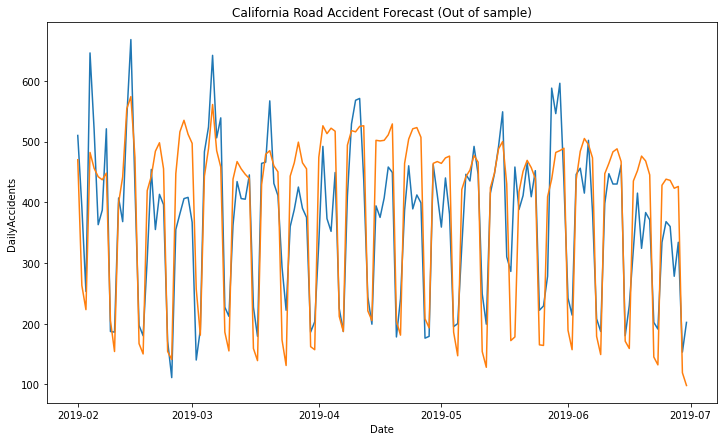

In [10]:
#plot california Forecast
forecast_all_df['DailyAccidents'] = forecast_all_df['DailyAccidents'].astype(int)
forecast_all_df['Forecast'] = forecast_all_df['Forecast'].astype(int)
plt.rcParams["figure.figsize"] = (12,7)
sn.lineplot(data = forecast_all_df.loc[forecast_all_df.State=="CA"], \
            x='Date', y='DailyAccidents')
sn.lineplot(data = forecast_all_df.loc[forecast_all_df.State=="CA"], \
            x='Date', y='Forecast').set_title('California Road Accident Forecast (Out of sample)');

# Seasonal ARIMA model

In [50]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings ("ignore") #ignore warnings

UniqueStates = df.State.unique()
features = ["Temperature", "Pressure", "Visibility"]#features
test_size=(pd.to_datetime(test_end_date) - pd.to_datetime(train_end_date)).days

dfcolumns = ["Date", "State", "DailyAccidents", "Forecast"]
forecast_all_df = pd.DataFrame(columns= dfcolumns)

#UniqueStates = ['CA']
#loop through each state to build time series models
for state in UniqueStates:
    print(state)
    
    localdf = train_df.loc[train_df.State == state].copy()#train df local copy
    
    #prepare y's
    y_to_train = train_df[['Date', 'DailyAccidents']]
    y_to_train.set_index('Date', inplace=True)
    y_to_test = test_df[['Date', 'DailyAccidents']]
    y_to_test.set_index('Date', inplace=True)
    
     # Fit model
    arima_model = auto_arima(y=y_to_train, seasonal=True, m=7, stepwise =True, d=1, \
                         start_p=1, max_p=2 , \
                         start_q =0, max_q=2 , \
                         start_d =1, max_d=1 , \
                         start_P =0, max_P=2 , \
                         start_Q =0, max_Q=2 , \
                         start_D =1, max_D=1 , \
                         D=1 )
    #forecast
    arima_forecast = arima_model.predict(n_periods=(pd.to_datetime(test_end_date)-pd.to_datetime(test_start_date)).days+1, \
                                         return_conf_int=True, alpha = .1)
    

    forecast_df = test_df.loc[test_df.State==state][['Date', 'State', 'DailyAccidents']].copy()
    forecast_df['Forecast'] = arima_forecast[0]    
    forecast_all_df = pd.concat([forecast_all_df , forecast_df])
    del forecast_df

MI
PA
CA
NY
IL
FL
SC
TX
GA
NC


Plot the Forecast & calcuate RMSE:
1. Models are able to pick up weekly seasonality pretty well
2. Model out of sample RMSE is shown below for each state

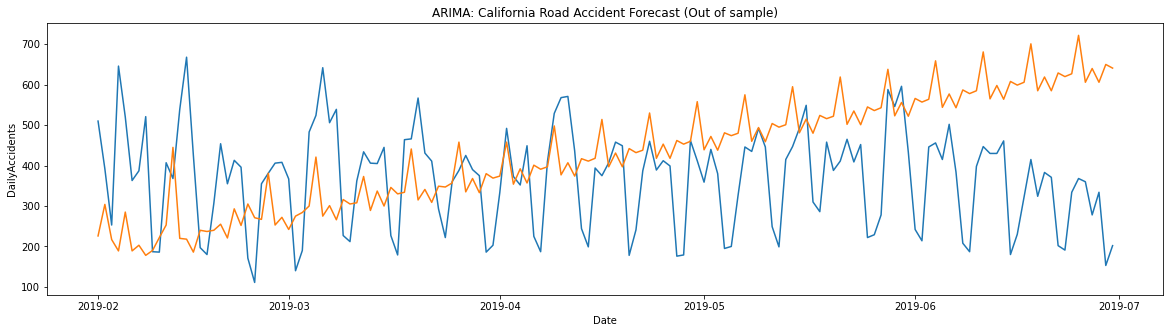

In [54]:
#plot california Forecast
forecast_all_df['DailyAccidents'] = forecast_all_df['DailyAccidents'].astype(int)
forecast_all_df['Forecast'] = forecast_all_df['Forecast'].astype(int)
plt.rcParams["figure.figsize"] = (20,5)
sn.lineplot(data = forecast_all_df.loc[forecast_all_df.State=="CA"], \
            x='Date', y='DailyAccidents')
sn.lineplot(data = forecast_all_df.loc[forecast_all_df.State=="CA"], \
            x='Date', y='Forecast').set_title('ARIMA: California Road Accident Forecast (Out of sample)');

In [52]:
from sklearn.metrics import mean_squared_error
rmse_list =[]
for state in UniqueStates:
    testdf = forecast_all_df.loc[forecast_all_df.State==state].copy()
    rmse = np.round(mean_squared_error(testdf.DailyAccidents, testdf.Forecast, squared=False),2)
    mean_accidents_actual = np.median(testdf[["DailyAccidents"]])
    rmse_list.append([state, rmse, 'SARIMA', mean_accidents_actual])

prophet_rmse = pd.DataFrame (rmse_list, columns=['State', 'RSME (test)', 'Model', 'ActualDailyAccidentsMedian'])
prophet_rmse.to_csv('SARIMA_RMSE.csv')
prophet_rmse.sort_values('ActualDailyAccidentsMedian', ascending=False)

,State,RSME (test),Model,ActualDailyAccidentsMedian
2,CA,197.62,SARIMA,388.5
7,TX,280.15,SARIMA,234.5
5,FL,305.06,SARIMA,178.0
6,SC,319.18,SARIMA,173.0
9,NC,341.65,SARIMA,148.0
3,NY,333.90,SARIMA,143.5
8,GA,383.62,SARIMA,76.0
4,IL,399.23,SARIMA,58.0
0,MI,398.22,SARIMA,56.0
1,PA,400.95,SARIMA,56.0


# RNN-LSTM Models

First create utility functions for running LSTM model:

In [41]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
 
train_start_date, train_end_date = '2016-02-09', '2018-12-31'
test_start_date, test_end_date = '2019-01-01', '2019-01-31'
val_start_date, val_end_date = '2019-02-01', '2019-06-30'#keep same as kept for ARIMA and prophet

#create static list of feature names
CAT_COLS = ['State']
NUM_COLS = ['Temperature', 'Visibility', 'DailyAccidents_Weekly', 'DailyAccidents_Yearly'] 
 
def create_supervise_dataset(df, ohe, minmaxscaler):
    train_df = df.loc[(df.Date>= train_start_date) & (df.Date <= train_end_date)]
    X_train = np.hstack((ohe.transform(train_df[CAT_COLS]), train_df[NUM_COLS]))
    X_train = minmaxscaler.fit(X_train).transform(X_train)
    Y_train = train_df[['DailyAccidents']]
  
    test_df = df.loc[(df.Date>= test_start_date) & (df.Date <= test_end_date)]
    X_test = np.hstack((ohe.transform(test_df[CAT_COLS]), test_df[NUM_COLS]))
    X_test = minmaxscaler.transform(X_test)
    Y_test = test_df[['DailyAccidents']]
  
    val_df = df.loc[(df.Date>= val_start_date) & (df.Date <= val_end_date)]
    X_val = np.hstack((ohe.transform(val_df[CAT_COLS]), val_df[NUM_COLS]))
    X_val = minmaxscaler.transform(X_val)
    Y_val = val_df[['DailyAccidents']]
  
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

Add seasonality features explicitly in the model:

In [30]:
TimeSeriesValues = df.State.unique()
 
lead_df_cols = ["Date_Yearly", "Date_Weekly", "DailyAccidents_Yearly", "DailyAccidents_Weekly", "State"] 
lead_df = pd.DataFrame(columns=lead_df_cols)
 
for timeseries in TimeSeriesValues:    
    localdf = df.loc[df.State==timeseries][["Date", "DailyAccidents", "State"]]
    localdf['DailyAccidents_Yearly'] = localdf['DailyAccidents']
    localdf['DailyAccidents_Weekly'] = localdf['DailyAccidents']    
    localdf["Date_Yearly"] = localdf.Date + pd.DateOffset(days=365)
    localdf["Date_Weekly"] = localdf.Date + pd.DateOffset(days=7)
    localdf.drop(['Date', 'DailyAccidents' ], inplace=True, axis=1)
    lead_df = pd.concat([lead_df,localdf])

lead_df.reset_index().drop('index',  inplace=True, axis=1)

df = (pd.merge(df, lead_df[['Date_Weekly', 'State', 'DailyAccidents_Weekly' ]], how = 'left', left_on=['Date', 'State'], right_on=['Date_Weekly', 'State']))
df = (pd.merge(df, lead_df[['Date_Yearly', 'State', 'DailyAccidents_Yearly' ]], how = 'left', left_on=['Date', 'State'], right_on=['Date_Yearly', 'State']))
df.drop(['Date_Weekly', 'Date_Yearly'], inplace=True, axis=1)
df.tail(20)

,Date,State,Temperature,DailyAccidents,Pressure,Visibility,Weather_Condition,DailyAccidents_Weekly,DailyAccidents_Yearly
16759,2020-12-30,CA,49.259940,2012,29.695388,9.213773,Cloudy,2017,726
16760,2020-12-30,FL,70.108538,1382,30.108175,9.848059,Cloudy,1818,127
16761,2020-12-30,GA,49.307692,91,29.274396,9.263736,Cloudy,114,42
16762,2020-12-30,IL,32.366492,191,29.225497,7.178010,Cloudy,106,106
16763,2020-12-30,MI,34.779904,209,29.018647,8.236842,Cloudy,74,99
16764,2020-12-30,NC,37.468864,273,29.571209,8.468864,Light Rain,338,70
16765,2020-12-30,NY,34.022654,309,29.835696,9.967638,Cloudy,353,79
16766,2020-12-30,PA,35.014440,277,29.602218,9.935018,Cloudy,443,57
16767,2020-12-30,SC,43.368902,328,29.817713,9.356707,Cloudy,385,183
16768,2020-12-30,TX,54.062344,802,29.393466,8.386534,Cloudy,550,140


Train a single LSTM model for all States:

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.callbacks import EarlyStopping
from matplotlib import pyplot

df.dropna(inplace=True)
df_copy = df.copy()#remove records adding yearly seasonality

#one hot encoding based on train set
ohe = OneHotEncoder(sparse=False, drop='first').fit(df_copy.loc[df_copy.Date <= train_end_date][CAT_COLS])
encoded_X = ohe.transform(df_copy[CAT_COLS]) #later use for decoding

#normalize features
minmaxscaler_X = MinMaxScaler(feature_range=(0, 1))
minmaxscaler_Y = MinMaxScaler(feature_range=(0, 1))
 
#train test prepare
X_train, X_test, X_val, Y_train, Y_test, Y_val = create_supervise_dataset(df_copy, ohe, minmaxscaler_X)
Y_train= minmaxscaler_Y.fit_transform(Y_train)
Y_test = minmaxscaler_Y.transform(Y_test)
Y_val = minmaxscaler_Y.transform(Y_val)
 
print('shape before reshape')
print(X_train.shape, X_test.shape, X_val.shape)
print(Y_train.shape, Y_test.shape, Y_val.shape)
 
# reshape input to be 3D [samples, timesteps, features]
print('shape after reshape')
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
print(X_train.shape, X_test.shape, X_val.shape)
 
# design network
model = Sequential()
model.add(LSTM(25, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
#early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)
# fit network
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=2, shuffle=False, callbacks=[es]) #, stateful=True

shape before reshape
(5824, 13) (310, 13) (1500, 13)
(5824, 1) (310, 1) (1500, 1)
shape after reshape
(5824, 1, 13) (310, 1, 13) (1500, 1, 13)
Train on 5824 samples, validate on 310 samples
Epoch 1/100
5824/5824 - 2s - loss: 0.0212 - val_loss: 0.0095
Epoch 2/100
5824/5824 - 0s - loss: 0.0110 - val_loss: 0.0057
Epoch 3/100
5824/5824 - 0s - loss: 0.0087 - val_loss: 0.0046
Epoch 4/100
5824/5824 - 0s - loss: 0.0079 - val_loss: 0.0043
Epoch 5/100
5824/5824 - 0s - loss: 0.0077 - val_loss: 0.0042
Epoch 6/100
5824/5824 - 0s - loss: 0.0073 - val_loss: 0.0041
Epoch 7/100
5824/5824 - 0s - loss: 0.0071 - val_loss: 0.0041
Epoch 8/100
5824/5824 - 0s - loss: 0.0073 - val_loss: 0.0042
Epoch 9/100
5824/5824 - 0s - loss: 0.0071 - val_loss: 0.0041
Epoch 10/100
5824/5824 - 0s - loss: 0.0076 - val_loss: 0.0041
Epoch 11/100
5824/5824 - 0s - loss: 0.0071 - val_loss: 0.0041
Epoch 12/100
5824/5824 - 0s - loss: 0.0075 - val_loss: 0.0041
Epoch 13/100
5824/5824 - 0s - loss: 0.0076 - val_loss: 0.0041
Epoch 14/100


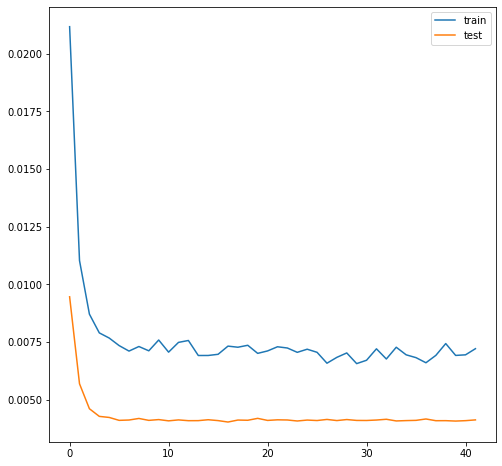

In [121]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [122]:
X_train, X_test, X_val, Y_train, Y_test, Y_val = create_supervise_dataset(df_copy, ohe, minmaxscaler_X)
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_Forecast = pd.DataFrame(minmaxscaler_Y.inverse_transform(((model.predict(X_val)))), columns=['Forecast']).round(0)

forecast_all_df = df.loc[(df.Date>= val_start_date) & (df.Date <= val_end_date)].reset_index()
forecast_all_df['Forecast'] = X_test_Forecast['Forecast']
forecast_all_df.head(5)

,index,Date,State,Temperature,DailyAccidents,Pressure,Visibility,Weather_Condition,DailyAccidents_Weekly,DailyAccidents_Yearly,Forecast
0,9807,2019-02-01,CA,55.750980,510,29.891209,9.243627,Overcast,514,462,437.0
1,9808,2019-02-01,FL,66.583516,182,30.201648,9.317582,Heavy Rain,187,269,198.0
2,9809,2019-02-01,GA,42.603750,80,30.324875,9.550000,Clear,91,108,89.0
3,9810,2019-02-01,IL,7.940476,168,30.343036,7.997024,Clear,159,93,123.0
4,9811,2019-02-01,MI,5.286719,128,30.383125,9.886719,Partly Cloudy,141,65,91.0


In [123]:
from sklearn.metrics import mean_squared_error
rmse_list =[]
for state in df.State.unique():
    testdf = forecast_all_df.loc[forecast_all_df.State==state].copy()
    rmse = np.round(mean_squared_error(testdf.DailyAccidents, testdf.Forecast, squared=False),2)
    mean_accidents_actual = np.median(testdf[["DailyAccidents"]])
    rmse_list.append([state, rmse, 'LSTM_1', mean_accidents_actual])

lstm_rmse = pd.DataFrame (rmse_list, columns=['State', 'RSME (test)', 'Model', 'ActualDailyAccidentsMedian'])
lstm_rmse.sort_values('ActualDailyAccidentsMedian', ascending=False).to_csv('LSTM_4.csv')
lstm_rmse.sort_values('ActualDailyAccidentsMedian', ascending=False)

,State,RSME (test),Model,ActualDailyAccidentsMedian
2,CA,93.66,LSTM_1,388.5
7,TX,57.20,LSTM_1,234.5
5,FL,45.58,LSTM_1,178.0
6,SC,42.97,LSTM_1,173.0
9,NC,48.32,LSTM_1,148.0
3,NY,43.33,LSTM_1,143.5
8,GA,23.47,LSTM_1,76.0
4,IL,25.88,LSTM_1,58.0
0,MI,24.42,LSTM_1,56.0
1,PA,22.98,LSTM_1,56.0


(2.0, 668.0)

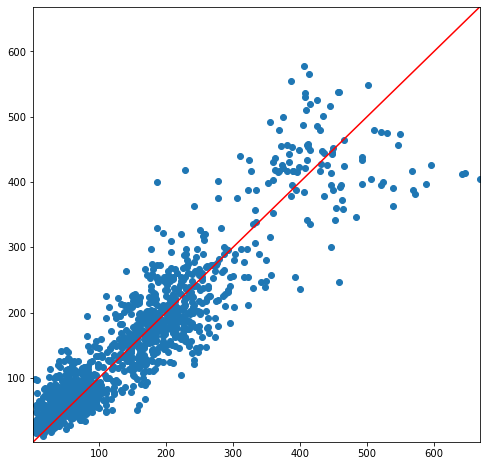

In [93]:
test = forecast_all_df
 
lineStart = test.DailyAccidents.min() 
lineEnd = test.DailyAccidents.max()  
 
plt.close("all")
plt.rcParams["figure.figsize"] = [8,8]
 
plt.scatter(test['DailyAccidents'],test['Forecast'])
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)